In [1]:
# from jaxtyping import Int, Bool, Float
# from itertools import product
# import numpy as np


# def generate_coords_2d(resolution: tuple[int, int]) -> Float[np.ndarray, "X Y 2"]:
#     a = generate_coords_1d(resolution[0])
#     b = generate_coords_1d(resolution[1])
#     A, B = np.meshgrid(a, b)

#     # Flatten the arrays and pair them
#     return np.array([A, B]).T


# def generate_coords_1d(resolution: int) -> list[float]:
#     return np.linspace(0, 1, resolution + 1)[1:] - 1 / (2 * resolution)


# def get_upscaling_pixel_indices_and_distances(
#     start_resolution: tuple[int, int], end_resolution: tuple[int, int]
# ) -> tuple[Int[np.ndarray, "4 XUpscaled YUpscaled 2"], Float[np.ndarray, "4 XUpscaled YUpscaled 2"], Bool[np.ndarray, "4 XUpscaled YUpscaled"]]:
#     start_coords = generate_coords_2d(start_resolution)
#     end_coords = generate_coords_2d(end_resolution)
#     nearest_pixels = np.zeros((4, *end_resolution, 2))

#     for i_end, j_end in product(range(end_resolution[0]), range(end_resolution[1])):
#         end_coord = end_coords[i_end, j_end]
#         nearest_pixel = np.floor(end_coord * start_resolution).astype(int)
#         vector_from_nearest_start_to_end = end_coord - start_coords[nearest_pixel[0], nearest_pixel[1]]
#         next_x, next_y = (vector_from_nearest_start_to_end > 0) * 2 - 1

#         nearest_pixels[0, i_end, j_end] = nearest_pixel
#         nearest_pixels[1, i_end, j_end] = np.array([nearest_pixel[0] + next_x, nearest_pixel[1]])
#         nearest_pixels[2, i_end, j_end] = np.array([nearest_pixel[0], nearest_pixel[1] + next_y])
#         nearest_pixels[3, i_end, j_end] = np.array([nearest_pixel[0] + next_x, nearest_pixel[1] + next_y])

#     x_out_of_bounds = np.logical_or(nearest_pixels[..., 0] < 0, nearest_pixels[..., 0] >= start_coords.shape[0])
#     y_out_of_bounds = np.logical_or(nearest_pixels[..., 1] < 0, nearest_pixels[..., 1] >= start_coords.shape[1])
#     out_of_bounds = np.logical_or(x_out_of_bounds, y_out_of_bounds)
#     nearest_pixels[out_of_bounds] = 0

#     nearest_pixels = nearest_pixels.astype(int)

#     nearest_start_coords = start_coords[nearest_pixels[..., 0], nearest_pixels[..., 1]]
#     start_to_end_vectors = end_coords[None, :] - nearest_start_coords

#     return nearest_pixels, start_to_end_vectors, out_of_bounds

In [2]:
from dynamic_fusion.utils.superresolution import get_upscaling_pixel_indices_and_distances, generate_coords_2d

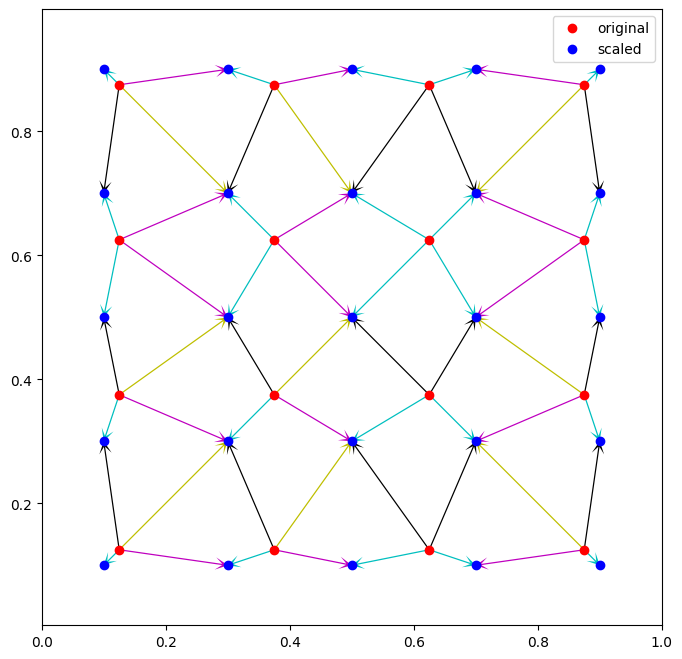

In [4]:
from matplotlib import pyplot as plt
import numpy as np

start_resolution = (4,4)
end_resolution = (5,5)
nearest, vectors, out_of_bounds = get_upscaling_pixel_indices_and_distances(start_resolution, end_resolution)
start_coords = generate_coords_2d(start_resolution)
end_coords = generate_coords_2d(end_resolution)

flat_start = np.reshape(start_coords, (-1, 2))
flat_end = np.reshape(end_coords, (-1, 2))
plt.figure(0, (8,8))

plt.plot(flat_start[:, 0], flat_start[:,1], 'or', label='original')
plt.plot(flat_end[:, 0], flat_end[:,1], 'ob', label='scaled')
plt.legend()

colors = ['c', 'm', 'k', 'y']

for i, (index, vector, invalid, color) in enumerate(zip(nearest, vectors, out_of_bounds, colors)):
    vector = vector*(1-invalid[..., None])
    current_start_coord = start_coords[index[..., 0], index[..., 1]]
    
    plt.quiver(current_start_coord[..., 0], current_start_coord[..., 1], vector[..., 0], vector[..., 1], scale=1, scale_units='xy', color=color, width=0.002, headwidth=10,headlength=10)
    if i > 2:
        break
plt.axis('equal')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [20]:
import einops
import numpy as np

latent_code = np.random.rand(16, *start_resolution, 8)
used_latent_codes = latent_code[:, nearest[..., 0], nearest[..., 1], :]

b, n,x,y,c = used_latent_codes.shape

vectors_normalized = (vectors[None, :] * einops.repeat(np.array(start_resolution), "Dims -> B N X Y Dims", B = b, N = n, X = x, Y = y))

tau = 0.1
tau = np.array([tau])
tau_expanded = einops.repeat(tau, "1 -> B N X Y 1", B = b, N = n, X = x, Y = y)

In [21]:
network_input = np.concatenate([used_latent_codes, vectors_normalized, tau_expanded], axis=-1)
network_output = np.random.rand(*network_input.shape[:-1], 1)

In [124]:
distances = 1-np.abs(vectors_normalized)
weights = distances[..., 0]*distances[..., 1]
weighted_output = weights[..., None]*network_output
final_output = weighted_output.sum(axis=0)

In [125]:
final_output.shape

(5, 5, 1)